<a href="https://colab.research.google.com/github/Camouflage10/disease-spread-model/blob/Camouflage10-bagging/disease_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import seaborn as sn
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold


In [3]:
kfoldruns=10
#get rid of Unnamed: 0
#make combine data and add 

In [4]:
def getData():
  x = pd.read_csv('train_x.csv')
  y = pd.read_csv('dengue_labels_train.csv')
  y=y.drop(columns=['city','year','weekofyear'])
  test =pd.read_csv('test.csv')


  x['year']=x['year'].astype(int)
  x['city'].replace(['sj', 'iq'],[0, 1], inplace=True)
  x[['year2', 'month', 'day']] = x['week_start_date'].str.split('-', expand=True)
  x['month']=x['month'].astype(int)
  x['day']=x['day'].astype(int)
  x=x.drop(columns=['year2','week_start_date','Unnamed: 0'])
  
  test['year']=test['year'].astype(int)
  test['city'].replace(['sj', 'iq'],[0, 1], inplace=True)
  test[['year2', 'month', 'day']] = test['week_start_date'].str.split('-', expand=True)
  test['month']=test['month'].astype(int)
  test['day']=test['day'].astype(int)
  test=test.drop(columns=['year2','week_start_date','Unnamed: 0'])

  return x, y, test

In [5]:
#tremove features with a corrilation of less than abs(mincorr)
def removeFeatures(x,y,test,minCorr):
  x['total_cases']=y['total_cases']
  corrMatrix = x.corr()
  lastCol=corrMatrix['total_cases']
  x=x.drop(columns=['total_cases'])
  print(lastCol)
  features=list(lastCol.loc[abs(lastCol) > minCorr].index)
  features.remove('total_cases')
  x=x[features]
  test=test[features]
  corrMatrix = x.corr()
  print(len(x.columns))
  return x,test

In [6]:
def getParams(x_train, y_train, model, hyperbag):
  model = model()
  #Applying GridSearchCV to get the best value for hyperparameters
  gridbag = GridSearchCV(model, hyperbag, scoring='neg_mean_absolute_error', cv = 2, verbose = 1, n_jobs = -1)
  gridbag.fit(x_train, y_train)
  print(gridbag.best_params_)
  return gridbag.best_params_, pd.DataFrame(gridbag.cv_results_)

In [7]:

def getPreds(x_train, x_test, y_train, y_test, model):
  temp=sklearn.base.clone(model)
  temp.fit(x_train,y_train)
  preds = temp.predict(x_test)
  preds=[round(num) for num in preds]
  rmse = np.sqrt(mean_squared_error(y_test, preds))

  #MSE and RMSE
  mse = mean_squared_error(y_test, preds)
  print("MSE: %.2f" % mse)
  rmse = np.sqrt(mean_squared_error(y_test, preds))
  mae= mean_absolute_error(y_test,preds)
  print("RMSE: %f" % (rmse))
  print("MaE: %f" % (mae))
  bag2=sklearn.base.clone(bag)
  #accuracy score round preds
  round_preds=[round(num) for num in preds]
  accuracy = accuracy_score(y_test, round_preds)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  return temp,preds

In [8]:
#K-Fold cross-val
from sklearn.model_selection import RepeatedKFold
def kFoldValues(x,y,model,n):
  rkf = RepeatedKFold(n_splits=2, n_repeats=n)
  bagMae=[]
  for train_index, test_index in rkf.split(x,y):
    x_traint, x_testt= x.iloc[train_index], x.iloc[test_index]
    y_traint, y_testt =y.iloc[train_index], y.iloc[test_index]
    temp=sklearn.base.clone(model)
    temp.fit(x_traint,y_traint)
    preds = temp.predict(x_testt)
    mae= mean_absolute_error(y_testt,preds)
    bagMae.append(mae)

  bagMae=np.array(bagMae)
  print(bagMae)
  #sd and mean of mae
  return np.std(bagMae), np.mean(bagMae)


In [9]:
from pyparsing import results
testmincorr=[.1,.15,.2,.24,.26]
col=["mincorr","#features","bag_mae_std", "bag_mae_mean", "forest_mae_std", "forest_mae_mean"]
df=pd.DataFrame(columns=col)
bags=[]
forests=[]
for n in testmincorr:
  x,y,test1=getData()
  x, test1=removeFeatures(x,y,test1,n)
  features=int(len(x.columns))
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
  hyperbag={'n_estimators': [75,85,90],'max_features':[2,4,5,6]}
  bagparam,results=getParams(x_train, y_train, BaggingRegressor, hyperbag)
  hyperbag={'n_estimators': [75,85,175],'max_features':[2,4,5,6], 'max_depth': [5,10,20]}
  forestparam, results=getParams(x_train, y_train, RandomForestRegressor, hyperbag)
  bag = BaggingRegressor(n_estimators=bagparam['n_estimators'],
                       max_features= bagparam['max_features'],)
  forest=RandomForestRegressor(max_features=forestparam['max_features'],
                             n_estimators=forestparam['n_estimators'],
                             max_depth=forestparam['max_depth'])
  bags.append(bag)
  forests.append(forest)
  bagstd, bagmean=kFoldValues(x,y,bag, kfoldruns)
  foreststd, forestmean=kFoldValues(x,y,forest, kfoldruns)
  df.loc[len(df)]=[n,features,bagstd,bagmean,foreststd,forestmean]
df


weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
station_min_temp_c                       0.259204
city                                    -0.292624
year                                    -0.306806
month                                    0.215737
day                                     -0.022562


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 6, 'n_estimators': 75}
Fitting 2 folds for each of 36 candidates, totalling 72 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 20, 'max_features': 5, 'n_estimators': 85}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[16.91126374 16.23085464 15.03690476 17.56031705 17.83911477 15.46570696
 15.30470277 17.35239027 17.81280525 15.61293433 16.67482413 16.5109707
 15.04531136 16.55231415 17.1643721  16.21557173 15.51102366 17.07925148
 17.81751435 16.75384829]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[15.42883016 14.38298586 14.92573362 15.55636471 15.12141317 15.06979751
 15.79341202 14.36539076 17.18565663 15.98718206 15.65264505 15.41347854
 14.54695489 16.18153828 15.46590863 15.13816059 16.46864307 14.30709783
 14.81374025 15.61042998]
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
stati

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 5, 'n_estimators': 85}
Fitting 2 folds for each of 36 candidates, totalling 72 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 10, 'max_features': 6, 'n_estimators': 85}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[14.74305376 16.63026826 16.36949082 14.57519392 15.44380899 15.51227914
 15.73180349 16.70210046 16.68526718 16.18512443 16.79210003 15.61373088
 16.92511945 15.41752586 15.40262497 17.04463693 16.85024087 16.2136393
 15.9232054  15.78314399]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[15.29215264 13.64863371 14.60891899 14.37009663 15.21224945 14.26025199
 15.2975873  14.68528175 13.71937637 15.90804985 15.17609205 14.72089764
 15.34978332 14.85198793 12.90149581 15.75798061 14.75743369 14.44173994
 13.86183271 15.61140856]
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
stati

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 6, 'n_estimators': 90}
Fitting 2 folds for each of 36 candidates, totalling 72 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_depth': 10, 'max_features': 4, 'n_estimators': 75}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[14.57124033 14.73120421 16.260058   14.89250556 15.98637057 14.25561733
 15.94872049 15.17095543 15.7415293  14.10068277 14.83196225 15.01306217
 14.90246617 15.27716143 16.54120879 13.82807096 14.91899674 14.33684549
 14.15981498 15.40277905]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[14.38808695 15.60087102 14.43883351 15.16861304 14.00821279 16.50332785
 15.34471261 14.63175316 14.4858392  15.80890215 14.1880328  14.62617477
 15.56729473 14.38444803 14.49594867 16.06887322 13.86813038 14.85713405
 15.05740355 15.67519164]
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
stati

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 6, 'n_estimators': 90}
Fitting 2 folds for each of 36 candidates, totalling 72 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 10, 'max_features': 5, 'n_estimators': 175}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[16.15192308 16.78183252 15.3475814  17.48521062 16.42807438 16.38046126
 14.51656517 16.70077839 16.30375458 17.043341   15.11098901 17.28512363
 15.2445406  16.54223138 17.5897703  14.93270757 16.09922161 16.68510379
 15.75833435 16.36938645]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[14.72356473 16.82079064 16.0042322  16.02925384 15.27628388 16.22029188
 16.42446234 15.56968654 16.67848071 15.86306118 15.5729318  16.49676541
 16.55755149 15.45545029 14.64164964 16.29624286 15.27257877 16.18870532
 15.32372128 16.43895169]
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
stati

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py", line 269, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py", line 342, in _fit
    raise ValueError("max_features must be in (0, n_f

{'max_features': 4, 'n_estimators': 75}
Fitting 2 folds for each of 36 candidates, totalling 72 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/para

{'max_depth': 20, 'max_features': 2, 'n_estimators': 75}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[17.52653846 18.07642857 17.84184066 17.78443223 18.83020513 17.94576557
 17.06381136 18.18765568 19.63551282 16.79672161 18.34154029 16.85453846
 17.13485348 18.02692308 18.26483516 17.68282051 16.41619048 19.98543407
 19.26587912 17.68443223]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[15.23169108 18.17319613 17.14590762 17.76458893 18.12713961 16.87813597
 16.75002981 16.77972582 17.35041635 17.49066309 17.18049608 17.49006912
 18.60184053 17.15951897 17.12393699 18.97323866 18.09755159 16.12539474
 16.63890546 17.32398938]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


,mincorr,#features,bag_mae_std,bag_mae_mean,forest_mae_std,forest_mae_mean
0,0.10,19.0,0.916805,16.522600,0.721541,15.370768
1,0.15,14.0,0.706620,16.027218,0.755891,14.721663
2,0.20,12.0,0.735199,15.043563,0.711266,14.958389
3,0.24,7.0,0.836124,16.237847,0.619462,15.892733
4,0.26,4.0,0.908512,17.967318,0.830510,17.320322


In [10]:
bag_index=df[['bag_mae_mean']].idxmin()
forest_index=df[['forest_mae_mean']].idxmin() 
bag_model=sklearn.base.clone(bags[int(bag_index)])
forest_model=sklearn.base.clone(forests[int(forest_index)])
b_minCorr=float(df.iloc[bag_index]['mincorr'])
f_minCorr=float(df.iloc[forest_index]['mincorr'])
if float(df.iloc[bag_index]['bag_mae_mean'])< float(df.iloc[forest_index]['forest_mae_mean']):
  #use min corr and model of index
  best_index=bag_index
  best_minCorr=b_minCorr
  model=sklearn.base.clone(bag_model)
else:
   best_index=forest_index
   best_minCorr=f_minCorr
   model=sklearn.base.clone(forest_model)

In [11]:
#create metrics.json (optional metrics.txt also)
row=df.iloc[best_index]
value = {
        "bag_mae_std": float(row["bag_mae_std"]),
        "bag_mae_mean": float(row["bag_mae_mean"]),
        "forest_mae_std": float(row["forest_mae_std"]),
        "forest_mae_mean": float(row["forest_mae_mean"])
    }
with open('metrics.json', 'w') as outfile:
  outfile.write(json.dumps(value))

In [14]:
x,y,test=getData()
b_x, test1=removeFeatures(x,y,test,b_minCorr)
f_x, test1=removeFeatures(x,y,test,f_minCorr)
x_train1, x_test1, y_train1, y_test1 = train_test_split(b_x, y, test_size=0.33)
x_train2, x_test2, y_train2, y_test2 = train_test_split(f_x, y, test_size=0.33)
beg,bagpreds=getPreds(x_train1, x_test1, y_train1, y_test1, bag_model)
forest,forestpreds=getPreds(x_train2, x_test2, y_train2, y_test2, forest_model)
bagpreds=np.array(bagpreds)
forestpreds=np.array(forestpreds)
y_test=np.array(y_test1)
y_test=y_test.reshape(bagpreds.shape)

bagerror=y_test-bagpreds
foresterror=y_test-forestpreds

weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
station_min_temp_c                       0.259204
city                                    -0.292624
year                                    -0.306806
month                                    0.215737
day                                     -0.022562


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


MSE: 992.51
RMSE: 31.504149
MaE: 15.126819
Accuracy: 3.12%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


MSE: 702.13
RMSE: 26.497676
MaE: 13.781705
Accuracy: 4.78%


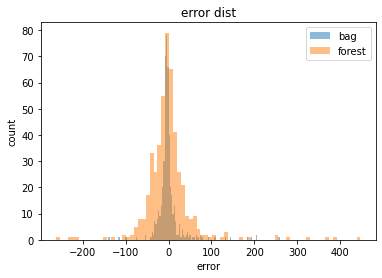

In [15]:
#visualization to see if it looks like it matches

#error=error.reshape(error.shape[0]*error.shape[1],1)
x_ax = range(len(y_test1))
plt.tight_layout()
fig1 = plt.gcf()
plt.hist(bagerror, bins='auto', alpha=.5, label='bag')
plt.hist(foresterror, bins='auto', alpha=.5, label='forest')
plt.title('error dist')
plt.xlabel('error')
plt.ylabel('count')
plt.legend()
plt.show()

#create a graph called stats.png
fig1.savefig('stats.png', dpi=100)

In [16]:
x,y,test=getData()
x, test=removeFeatures(x,y,test,best_minCorr)
model.fit(x,y)



weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
station_min_temp_c                       0.259204
city                                    -0.292624
year                                    -0.306806
month                                    0.215737
day                                     -0.022562


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(max_depth=10, max_features=6, n_estimators=85)

In [17]:
#submit predictions fo test
#first convert float array to int
pred = model.predict(test)
pred=[int(round(num)) for num in pred]
test_original =pd.read_csv('test.csv')
#test_original =pd.read_csv('dengue_features_test.csv')
#then make data frame for predicted data
submission=pd.DataFrame()
submission[['city', 'year', 'weekofyear']]=test_original[['city', 'year', 'weekofyear']]
submission['total_cases']=pred
#submission.sort_values(["city","year","weekofyear"],axis=0, ascending=True, inplace=True, na_position='first')
submission.to_csv('submission.csv', index=False)